## **Gold**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import time
import warnings
warnings.filterwarnings('ignore')

## **Cargar Datos**

In [2]:
month='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/refs/heads/main/Forecasting/stocks-shares/Data/monthly_csv.csv'
year='https://raw.githubusercontent.com/Saul-Ochoa/Time-Series/refs/heads/main/Forecasting/stocks-shares/Data/annual_csv.csv'

df_month=pd.read_csv(month,sep=',')
df_year=pd.read_csv(year,sep=',')

In [3]:
df_month.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
df_month['Date']=pd.to_datetime(df_month['Date'],format='%Y-%m')
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    847 non-null    datetime64[ns]
 1   Price   847 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.4 KB


In [5]:
df_year['Date']=pd.to_datetime(df_year['Date'],format='%Y-%m')
df_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    70 non-null     datetime64[ns]
 1   Price   70 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 KB


In [6]:
print(df_year.shape)
print(df_month.shape)

(70, 2)
(847, 2)


## **EDA**

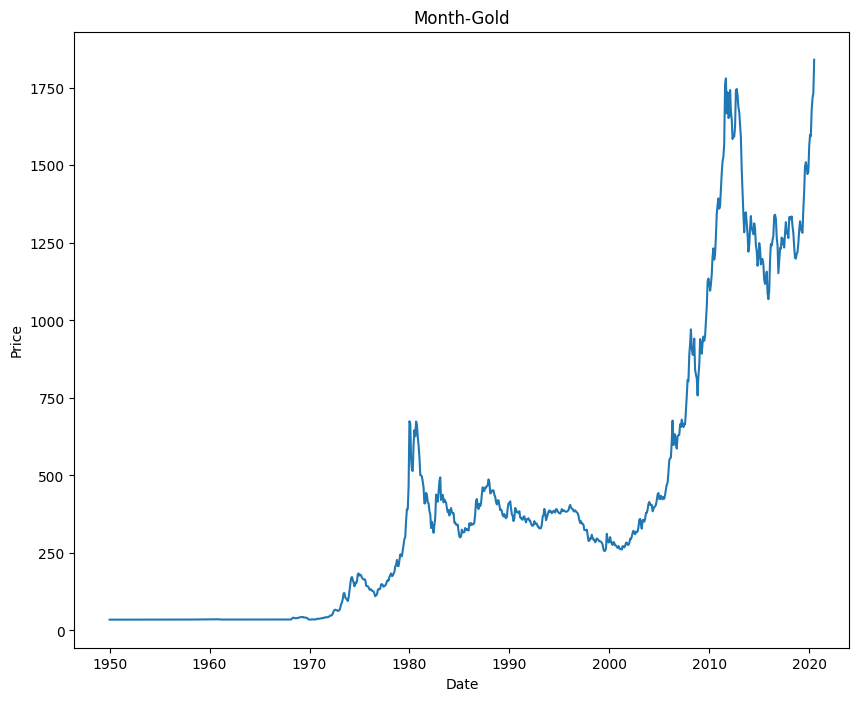

In [7]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df_month,x='Date',y='Price')
plt.title('Month-Gold')
plt.show()

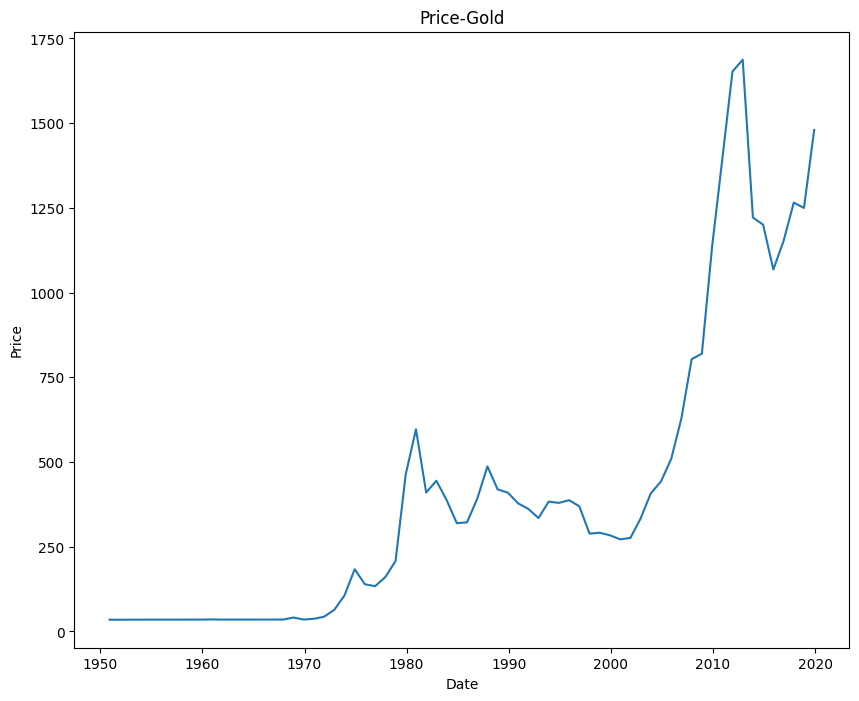

In [8]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df_year,x='Date',y='Price')
plt.title('Price-Gold')
plt.show()

In [9]:
df_month['Month']=df_month['Date'].dt.month
df_month['Year']=df_month['Date'].dt.year

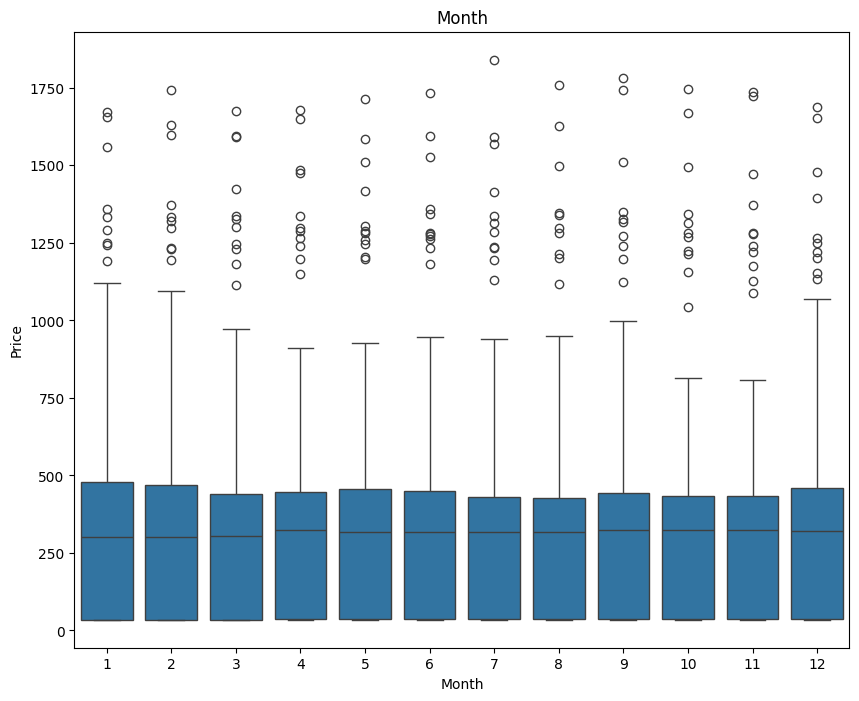

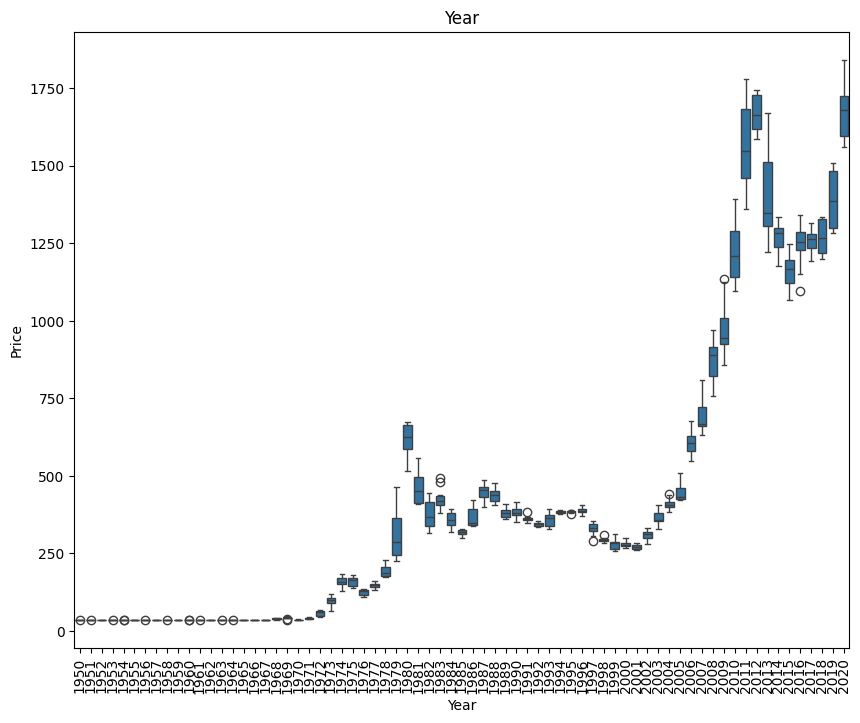

In [10]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_month,y='Price',x='Month')
plt.title('Month')
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(data=df_month,y='Price',x='Year')
plt.title('Year')
plt.xticks(rotation='vertical')
plt.show()

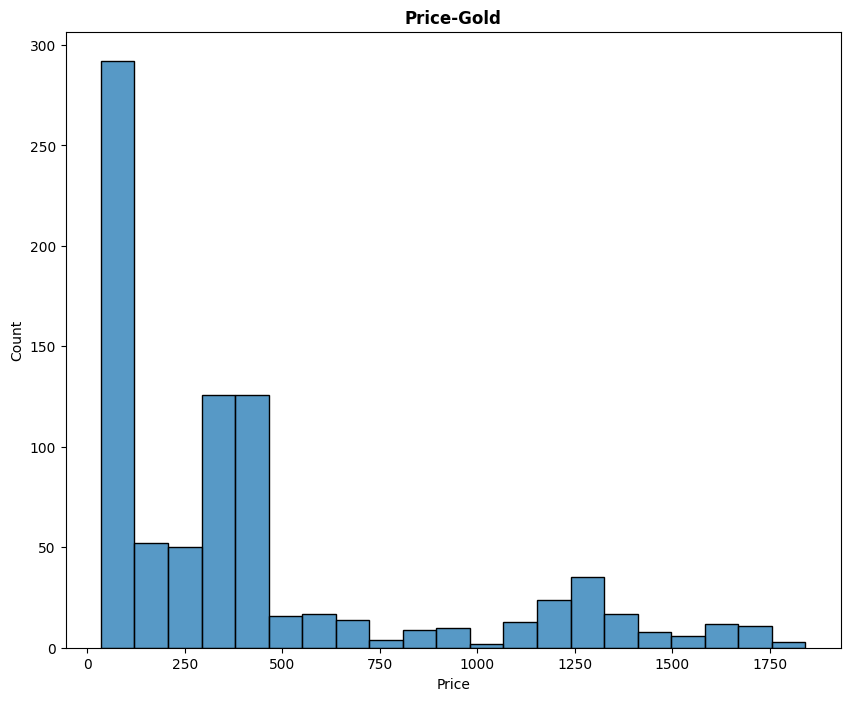

In [11]:
plt.figure(figsize=(10,8))
sns.histplot(data=df_month,x='Price')
plt.title('Price-Gold',fontsize=12,weight='bold')
plt.show()

<Figure size 1000x800 with 0 Axes>

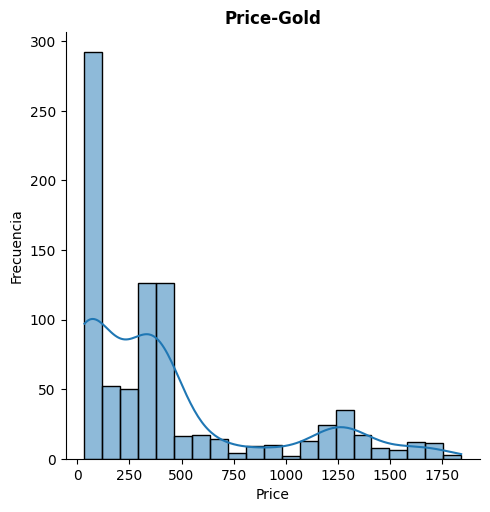

In [12]:
plt.figure(figsize=(10,8))
sns.displot(data=df_month,x='Price',kde=True)
plt.title('Price-Gold',fontsize=12,weight='bold')
plt.ylabel('Frecuencia')
plt.show()

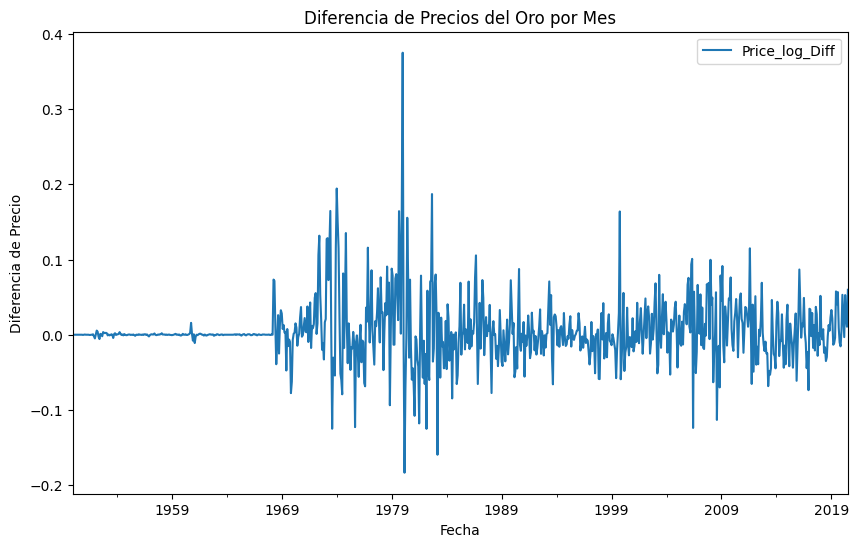

In [13]:
# Graficos por diferencia
df_month['Price_log']=df_month['Price'].apply(np.log)
df_month['Price_log_Diff']=df_month['Price_log'].diff()
df_month.plot(x='Date', y='Price_log_Diff', title='Diferencia de Precios del Oro por Mes', xlabel='Fecha', ylabel='Diferencia de Precio', figsize=(10,6))
plt.show()

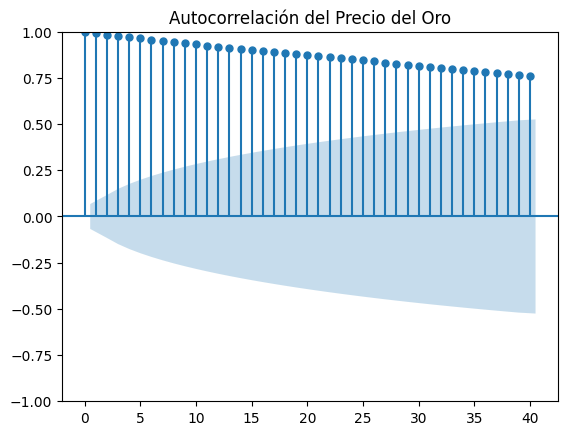

In [14]:
plot_acf(df_month['Price'], lags=40)
plt.title('Autocorrelación del Precio del Oro')
plt.show()

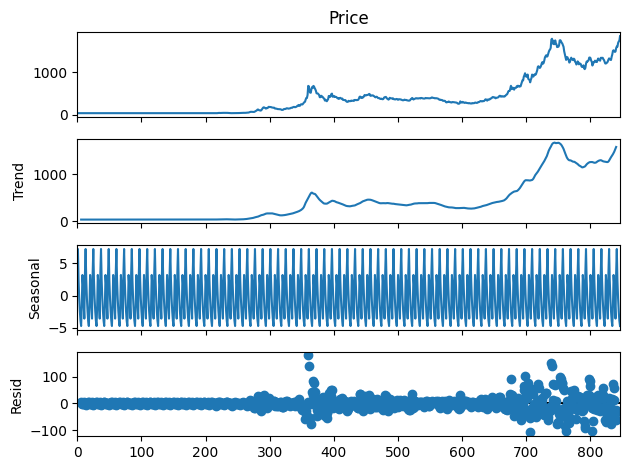

In [15]:
decomposition = seasonal_decompose(df_month['Price'], model='additive', period=12)
decomposition.plot()
plt.show()

## **Preparación de los datos**

In [16]:
def check_stationarity(dataframe, column):
    """
    Verifica la estacionariedad de una serie temporal usando pruebas ADF y KPSS.
    
    Parameters:
    dataframe: pd.DataFrame - DataFrame que contiene la serie temporal.
    column: str - Nombre de la columna que se analizará.
    
    Returns:
    None
    """
    # Prueba de Dickey-Fuller Aumentado (ADF)
    adf_result = adfuller(dataframe[column])
    adf_stat = adf_result[0].round(2)
    adf_pvalue = adf_result[1].round(2)

    # Prueba KPSS
    kpss_result = kpss(dataframe[column])
    kpss_stat = kpss_result[0].round(2)
    kpss_pvalue = kpss_result[1].round(2)

    # Imprimir resultados
    print(f'Estadístico ADF: {adf_stat}')
    print(f'p-value ADF: {adf_pvalue}')
    print(f'Estadístico KPSS: {kpss_stat}')
    print(f'p-value KPSS: {kpss_pvalue}')

    # Condicional para determinar estacionariedad
    if adf_pvalue < 0.05:
        print("La serie es estacionaria según la prueba de Dickey-Fuller (ADF).")
    else:
        print("La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).")

    if kpss_pvalue < 0.05:
        print("La serie NO es estacionaria según la prueba KPSS.")
    else:
        print("La serie es estacionaria según la prueba KPSS.")

# Uso de la función
check_stationarity(df_month, 'Price')

Estadístico ADF: 0.81
p-value ADF: 0.99
Estadístico KPSS: 3.27
p-value KPSS: 0.01
La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie NO es estacionaria según la prueba KPSS.


In [17]:
# Eliminar filas con valores nulos en 'Price_Diff'
df_month.dropna(subset=['Price_log_Diff'], axis=0, inplace=True)

In [18]:
df_month.columns

Index(['Date', 'Price', 'Month', 'Year', 'Price_log', 'Price_log_Diff'], dtype='object')

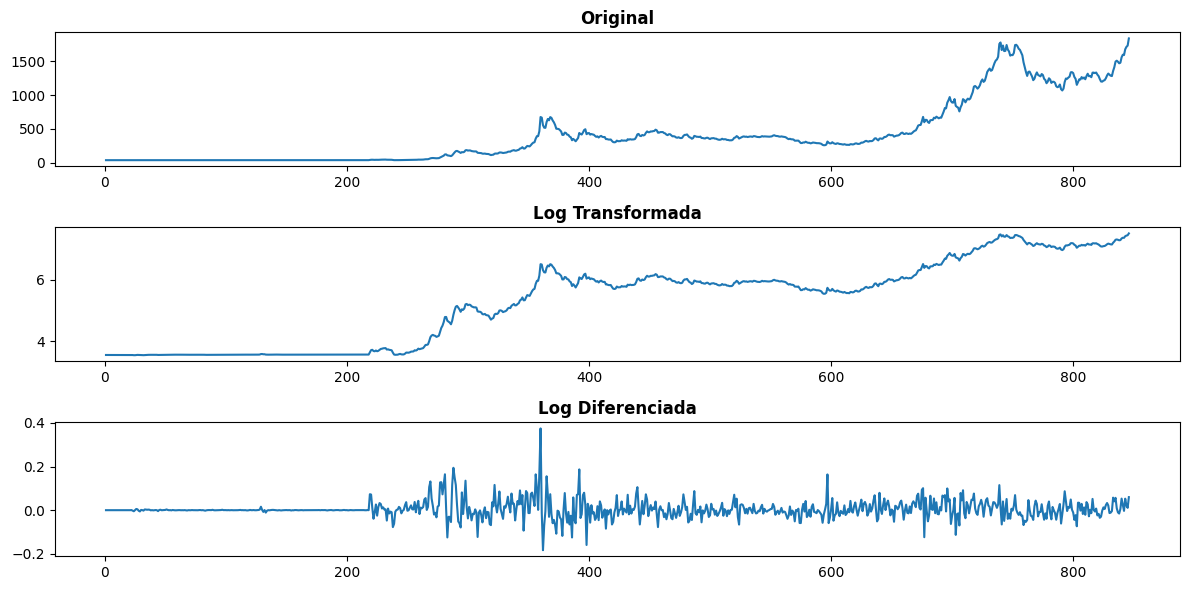

In [19]:
# Visualizar los datos originales y transformados
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(df_month.index, df_month['Price'], label='Original')
plt.title('Original',fontsize=12,weight='bold')

plt.subplot(3, 1, 2)
plt.plot(df_month.index, df_month['Price_log'], label='Log Transformada')
plt.title('Log Transformada',fontsize=12,weight='bold')

plt.subplot(3, 1, 3)
plt.plot(df_month.index, df_month['Price_log_Diff'], label='Log Diferenciada')
plt.title('Log Diferenciada',fontsize=12,weight='bold')

plt.tight_layout()
plt.show()

In [20]:
# Uso de la función
check_stationarity(df_month, 'Price_log')
# Uso de la función
check_stationarity(df_month, 'Price_log_Diff')

Estadístico ADF: -0.42
p-value ADF: 0.91
Estadístico KPSS: 4.06
p-value KPSS: 0.01
La serie NO es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie NO es estacionaria según la prueba KPSS.
Estadístico ADF: -5.87
p-value ADF: 0.0
Estadístico KPSS: 0.13
p-value KPSS: 0.1
La serie es estacionaria según la prueba de Dickey-Fuller (ADF).
La serie es estacionaria según la prueba KPSS.


In [21]:
df_month.columns

Index(['Date', 'Price', 'Month', 'Year', 'Price_log', 'Price_log_Diff'], dtype='object')

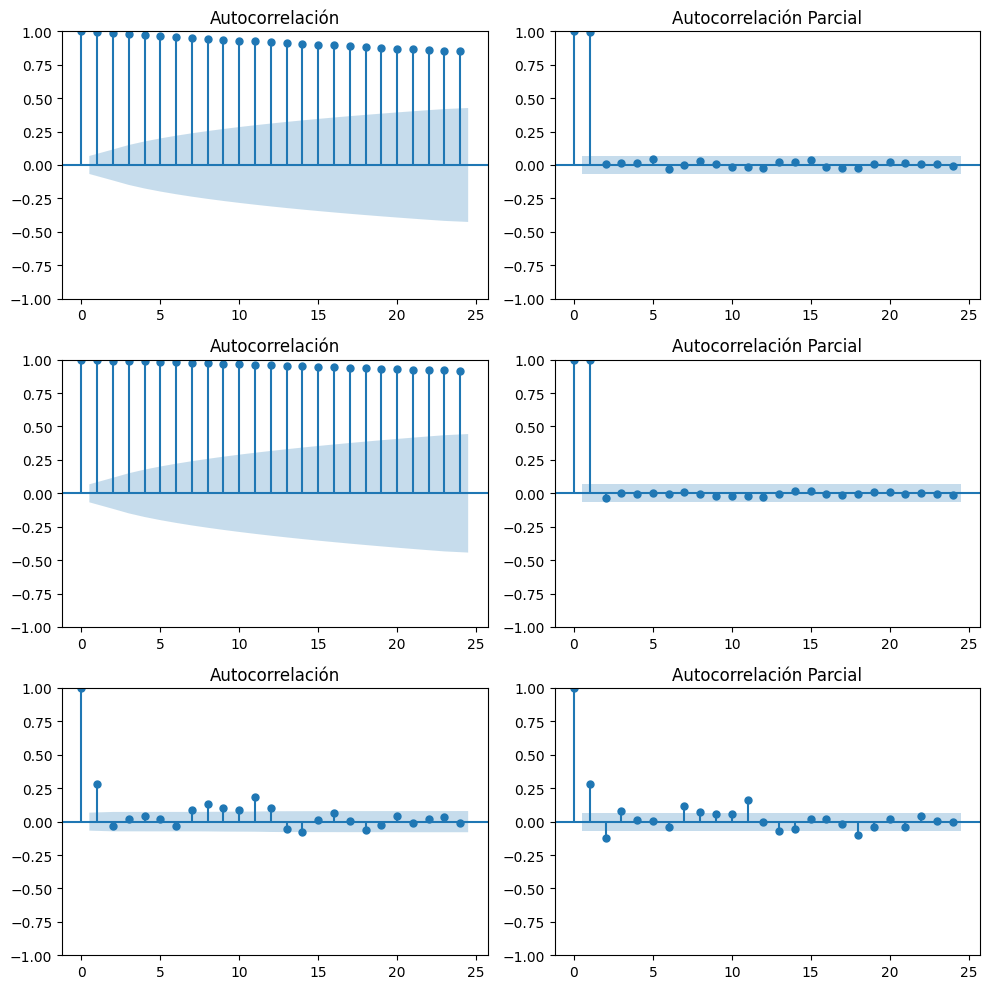

In [22]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(df_month['Price'], ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price'], ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(df_month['Price_log'], ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price_log'], ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(df_month['Price_log_Diff'], ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(df_month['Price_log_Diff'], ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()

## **Modelo de Series de Tiempos**

* Arima

In [23]:
df_new=df_month[['Date','Price_log_Diff']]
df_new.set_index('Date',inplace=True)
df_new.head()

,Price_log_Diff
Date,
1950-02-01,0.0
1950-03-01,0.0
1950-04-01,0.0
1950-05-01,0.0
1950-06-01,0.0


In [24]:
df_new.shape

(846, 1)

In [25]:
test_size=100
train_data=df_new[:-test_size].dropna()
test_data=df_new[-test_size:].dropna()
test=test_data.copy()

In [26]:
train_data.columns

Index(['Price_log_Diff'], dtype='object')

In [27]:
# Elegir p y q basándote en las gráficas (ejemplo: p=1, q=1)
p = 2
d = 1
q = 1

# Parámetros estacionales
P = 2  # Componente AR estacional
D = 1  # Diferenciación estacional
Q = 2  # Componente MA estacional
m = 12  # Número de períodos en un ciclo completo de estacionalidad (mensual, en este caso 12)


# Ajustar el modelo SARIMAX
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit(disp=False)

# Resumen del modelo
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                          Price_log_Diff   No. Observations:                  746
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                1292.969
Date:                                 Mon, 14 Oct 2024   AIC                          -2569.937
Time:                                         20:19:09   BIC                          -2533.160
Sample:                                     02-01-1950   HQIC                         -2555.751
                                          - 03-01-2012                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2936      0.021     14.009      0.000       0.253       0

In [28]:
# Realizar predicciones
n_periods = len(test)  # Número de pasos a predecir igual a la longitud del conjunto de prueba
forecast = model_fit.forecast(steps=n_periods)

# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'RMSE: {rmse:.2f}')

RMSE: 0.03


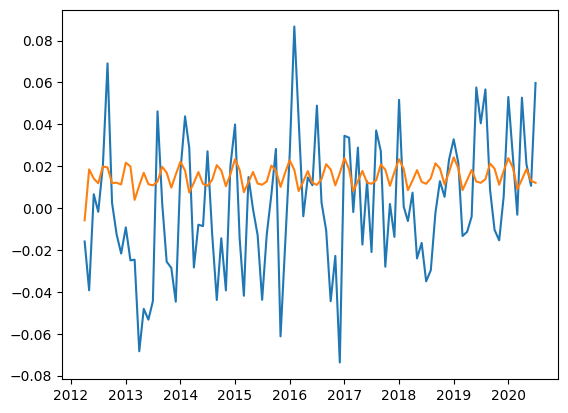

In [29]:
plt.plot(test)
plt.plot(forecast)
plt.show()

* Redes LSTM

In [45]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score

In [56]:
# Escalar los datos entre 0 y 1
df_new=df_month[['Date','Price']]
df_new.set_index('Date',inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_new)

#Convertir en formato
def create_sequences(data,seq_length):
    X,y=[],[]
    for i in range(len(data)-seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)
# Definir longitud de la secuencia (número de pasos previos usados para predecir)
sequence_length = 6  # Puedes ajustar este valor según el análisis de tu serie temporal
X, y = create_sequences(df_scaled, sequence_length)

# Separar en conjuntos de entrenamiento y prueba
split = int(0.8 * len(X))  # Usar el 80% para entrenamiento y el 20% para pruebas
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Redimensionar el conjunto para que LSTM lo entienda (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [57]:
from keras.layers import Dropout

# Crear el modelo LSTM
model = Sequential()

# Primera capa LSTM con Dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Elimina el 20% de las conexiones durante el entrenamiento para evitar sobreajuste

# Segunda capa LSTM con Dropout
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Tercera capa LSTM con Dropout
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Capa densa intermedia
model.add(Dense(units=50, activation='relu')) # Añade una capa densa para capturar relaciones no lineales

# Capa de salida
model.add(Dense(units=1))

# Compilar el modelo con un optimizador Adam con tasa de aprendizaje personalizada
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0115 - val_loss: 0.0072
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0272e-04 - val_loss: 0.0102
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7201e-04 - val_loss: 0.0037
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6063e-04 - val_loss: 0.0121
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4480e-04 - val_loss: 0.0160
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3589e-04 - val_loss: 0.0115
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.5020e-04 - val_loss: 0.0132
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7437e-04 - val_loss: 0.0128
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3791e-04 - val_loss: 0.0120
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7892e-04 - val_loss: 0.0107
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5796e-04 - val_loss: 0.0107
Epoch 12/50
21/21 ━━━━━

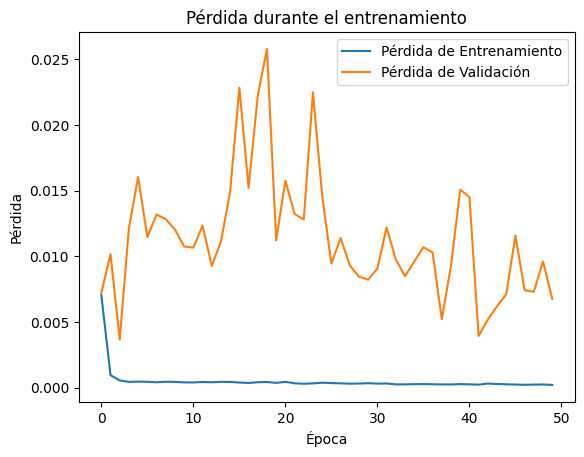

In [63]:
# Evaluar el modelo
# Graficar la pérdida del entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step


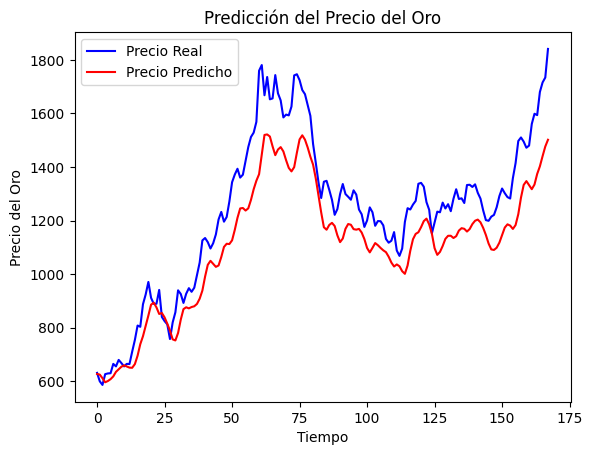

In [58]:
# Evaluar el modelo 
# Hacer predicciones
y_pred = model.predict(X_test)

# Invertir la escala para obtener los valores reales
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test.reshape(-1, 1))

# Comparar los valores reales vs. predichos
import matplotlib.pyplot as plt

plt.plot(y_test_inversed, color='blue', label='Precio Real')
plt.plot(y_pred_inversed, color='red', label='Precio Predicho')
plt.title('Predicción del Precio del Oro')
plt.xlabel('Tiempo')
plt.ylabel('Precio del Oro')
plt.legend()
plt.show()

In [62]:
# Calcular el MSE
mse = mean_squared_error(y_test_inversed, y_pred_inversed)

# Calcular el RMSE
rmse = np.sqrt(mse)

# Calcular el R²
r2 = r2_score(y_test_inversed, y_pred_inversed)

# Imprimir los resultados
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

MSE: 22026.416810559287
RMSE: 148.41299407585336
R²: 0.7474182243038403
